<a href="https://colab.research.google.com/github/RudyMartin/dsai-2024/blob/main/2024_project_template_v4char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Image Recognition Project Dataset

The dataset is collected by the previous code. The images directories are all located in separate folder in My Drive.  Change the rps_name at the top of the script to point to other image sets of rock paper scissors.

The dataset consists of multiple <b> 480x640x3</b> color images in 3 classes (scissors, rock and paper).

This file has a directory dependency. To properly import utility files it must be in the templates folder of the 2024 Rock Paper Scissor templates folder.

**RECOMMENDATION :** Start with your own images and compare your results to others in class. What do the result comparisons say about data quality?

In [8]:
# Initialize Google Drive, main folder for storing and accessing data directly
import os
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/'
rps_name = 'rps'
rps_dir = os.path.join(root_dir, rps_name)
if not os.path.exists(rps_dir):
    raise FileNotFoundError(f"Directory {rps_dir} does not exist.")
print(f"Images directory contents: {os.listdir(rps_dir)}")

# Define paths for data and models
train_dir = os.path.join(rps_dir, 'train')
test_dir = os.path.join(rps_dir, 'test')
model_dir = os.path.join(root_dir, 'model')
os.makedirs(model_dir, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Images directory contents: ['test', 'train']


# Import Packages and Global Values

In [9]:
#!pip install keras --upgrade

In [10]:
#!pip install tensorflow --upgrade

In [11]:
import keras
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
# from keras.optimizers import SGD
from keras.constraints import MaxNorm
from keras.utils import to_categorical
from keras.layers import GaussianNoise, GaussianDropout, Dense, Dropout, Flatten
#from keras.layers.advanced_activations import SReLU
#from keras.utils import plot_model
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
import os, sys, time, datetime, fnmatch
import numpy as np

In [12]:
## Older version uodated see github
## this is required to be sure the file reads the imported utility files
%cd '/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition/2024 Camp Rock Paper Scissors/Templates'
import dlutils
import kerutils
from dlutils import *
from kerutils import *

/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition/2024 Camp Rock Paper Scissors/Templates


# Loading Training and test data

Define classes using a dictionary

In [13]:
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}
classes=class_name

Let's draw an image in X_train for example

In [14]:
import cv2
import glob
#import numpy as np

# Training data
X_scissor_train = np.asarray([cv2.imread(file) for file in glob.glob(f'{train_dir}/scissors/*.jpg')])
y_scissor_train = np.zeros(X_scissor_train.shape[0])
X_rock_train = np.asarray([cv2.imread(file) for file in glob.glob(f'{train_dir}/rock/*.jpg')])
y_rock_train = np.zeros(X_rock_train.shape[0]) + 1
X_paper_train = np.asarray([cv2.imread(file) for file in glob.glob(f'{train_dir}/paper/*.jpg')])
y_paper_train = np.zeros(X_paper_train.shape[0]) + 2

X_train = np.concatenate((X_scissor_train, X_rock_train, X_paper_train), axis=0)
y_train = np.concatenate((y_scissor_train, y_rock_train, y_paper_train), axis=0)

print(f"Number of training images: {X_train.shape[0]}")
print(f"Number of training labels: {y_train.shape[0]}")

# Testing data
X_scissor_test = np.asarray([cv2.imread(file) for file in glob.glob(f'{test_dir}/scissors/*.jpg')])
y_scissor_test = np.zeros(X_scissor_test.shape[0])
X_rock_test = np.asarray([cv2.imread(file) for file in glob.glob(f'{test_dir}/rock/*.jpg')])
y_rock_test = np.zeros(X_rock_test.shape[0]) + 1
X_paper_test = np.asarray([cv2.imread(file) for file in glob.glob(f'{test_dir}/paper/*.jpg')])
y_paper_test = np.zeros(X_paper_test.shape[0]) + 2

X_test = np.concatenate((X_scissor_test, X_rock_test, X_paper_test), axis=0)
y_test = np.concatenate((y_scissor_test, y_rock_test, y_paper_test), axis=0)

print(f"Number of testing images: {X_test.shape[0]}")
print(f"Number of testing labels: {y_test.shape[0]}")

Number of training images: 600
Number of training labels: 600
Number of testing images: 60
Number of testing labels: 60


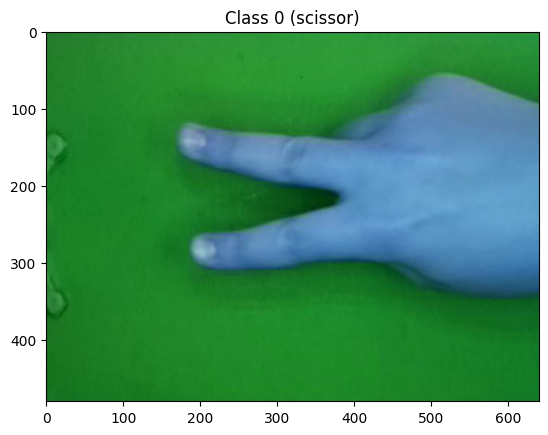

In [15]:
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

draw_img(10)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

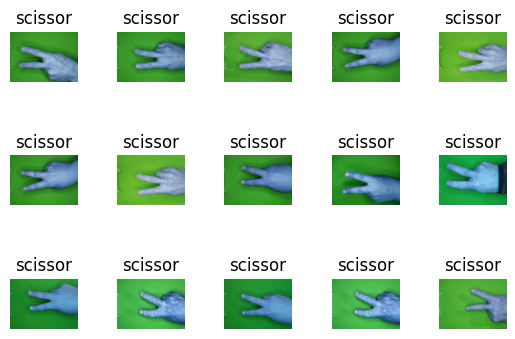

In [16]:
def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(480,640,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

draw_sample(X_train, y_train, 0,3,5)

Import Data

Normalize and Encode Datasets

In [17]:
seed = 123
np.random.seed(seed)

# Normalize the data
print(X_train.shape)
print(y_train.shape)

# Assuming X_test is your image data
img_height = X_test.shape[1]
img_width = X_test.shape[2]

print(f"Height: {img_height}")
print(f"Width: {img_width}")

# The original data of each image is a 480x640x3 matrix of integers from 0 to 255.
# We need to scale it down to floats in the unit interval
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

(600, 480, 640, 3)
(600,)
Height: 480
Width: 640


As usual, we must convert the y_train and y_test vectors to one-hot format:<br>
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]<br>
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]<br>
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]<br>

In [18]:
# One hot encode outputs
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
num_classes = Y_test.shape[1]

# Y_train = to_categorical(y_train, num_classes)
# Y_test = to_categorical(y_test, num_classes)

# Building Neural Network for the image set

The input layer would have to be of size 480x640x3. If we add a hidden layer with the same size, we'll end up with 9 milion synapses on the first floor. Adding one more layer of such size will take us to billions of synapses, which is of course impractical.<br>
Deep learning frameworks have come up with special types of designated layers for processing images. Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than pixels in a far away region of the image.<br>
We will start with a small Keras model which combines a well thought mix of <b>Convolution2D</b>, <b>Maxpooling2D</b> and Dense layers.<br>


# Let's Train Model

In [19]:
# Model Assumptions
num_epochs = 10 ## small batches are more likely to result in overfitting
batch_size = 50 ## should never be greater than # of images per class
## this is about 10% of 200 (200 per class * 3 classes = 600 images)
model_label = f"seq_{rps_name}_v1"


In [20]:
# Define Model

# this model does not contain dropout
model1 = Sequential(name=model_label)
model1.add(Convolution2D(4, 2, 2, input_shape=(img_height, img_width, 3), activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model1.add(Convolution2D(8, 2, 2, activation='relu')) # add parameters and activation function
model1.add(MaxPooling2D(pool_size=(2, 2))) # add parameters
model1.add(Flatten())
model1.add(Dense(32, activation='relu')) # add parameters and activation function
model1.add(Dense(num_classes, activation='softmax')) # activation function
# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_test, Y_test),
    shuffle=True
)


Model: "seq_rps_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 320, 4)       52        
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 160, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 80, 8)         136       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 40, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 32)                3

In [21]:
# save the model if it's needed (and copy this to keep track of different versions)
model1_file=f'{model_label}.keras'
model1.save(os.path.join(model_dir, model1_file))
print(f"Model saved to disk in the Keras format at {(os.path.join(model_dir, model1_file))}.")

Model saved to disk in the Keras format at /content/gdrive/My Drive/model/seq_rps_v1.keras.


In [22]:
def show_scores1(model, h, X_train, Y_train, X_test, Y_test):
    loss, acc = model.evaluate(X_train, Y_train, verbose=0)
    print ("Training: accuracy   = %.6f loss = %.6f" % (acc, loss))
    loss, acc = model.evaluate(X_test, Y_test, verbose=0)
    print ("Validation: accuracy = %.6f loss = %.6f" % (acc, loss))
    if 'val_acc' in h.history:
        print ("Over fitting score   = %.6f" % over_fitting_score(h))
        print ("Under fitting score  = %.6f" % under_fitting_score(h))
    print ("Params count:", model.count_params())
    print ("stop epoch =", max(h.epoch))
    print ("num_epochs =", h.params['epochs'])
    #print ("batch_size =", h.params['batch_size'])
    #print ("nb_sample =", h.params['samples'])
    view_acc1(h)
    id = model.name[-1]
    plt.savefig(model.name + '_acc_graph.png')
    plt.show()
    view_loss(h)
    plt.savefig(model.name + '_loss_graph.png')
    plt.show()


In [23]:
def view_acc1(h):
    # Accuracy history graph
    plt.plot(h.history['accuracy'])
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    leg = plt.legend(['train', 'validation'], loc='best')
    plt.setp(leg.get_lines(), linewidth=3.0)


In [24]:
# load model if not run recently or want to revert to past model
# model_file="model_10.h5"
# model_dir="/content/gdrive/My Drive/dscamp/dscamp_public/Project Object Recognition/2024 Camp Rock Paper Scissors/Templates/models/"
## ONLY DO THIS IF NOT RUNNING MODEL IN SAME NOTEBOOK
## model1 = load_model(os.path.join(model_dir, model1_file))

Training: accuracy   = 0.976667 loss = 0.083623
Validation: accuracy = 0.866667 loss = 0.540939
Params count: 307519
stop epoch = 9
num_epochs = 10


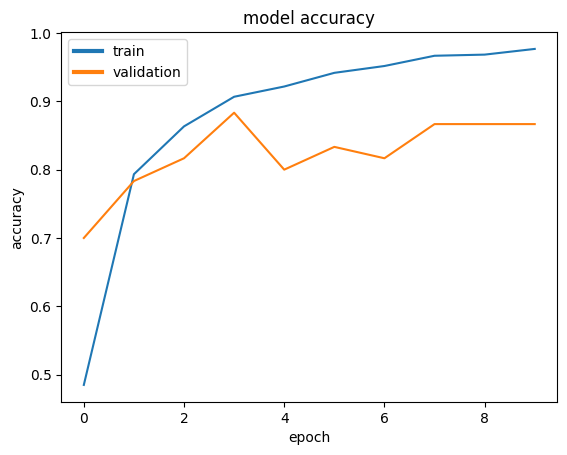

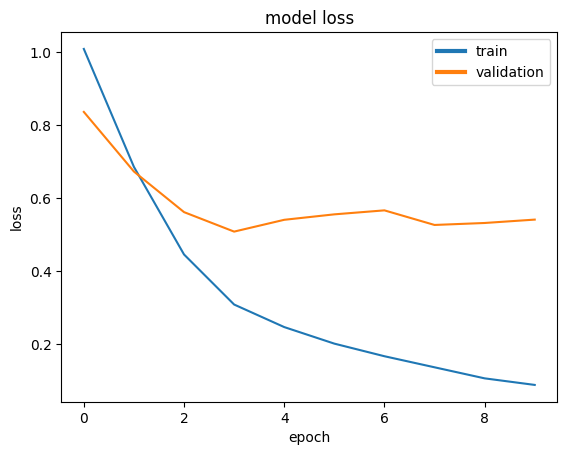

In [25]:
## print both model accuracy and model loss by epoch
show_scores1(model1, h, X_train, Y_train, X_test, Y_test)

In [26]:
loss, accuracy = model1.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy1 = %f  ;  loss1 = %f" % (accuracy, loss))

Training: accuracy = 0.976667  ;  loss = 0.083623
Validation: accuracy1 = 0.866667  ;  loss1 = 0.540939


# Inspecting Output

Neverthelss, befor we search for a new model, let's take a quick look on some of the cases that our model1 missed. It may give us hints on the strengths an weaknesses of NN models, and what we can expect from these artificial models.<br>
The predict_classes method is helpful for getting a vector (y_pred) of the predicted classes of model1. We should compare y_pred to the expected true classes y_test in order to get the false cases:

In [27]:
import cv2
import glob
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, jaccard_score, precision_score, recall_score, roc_auc_score, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


**MAKE PREDICTIONS**: This is were the model is applied to the dataset

In [28]:
# Make predictions

predict_x = model1.predict(X_test)
y_pred = np.argmax(predict_x, axis=1)

# Separate true and false predictions
true_preds = [(x, y, p) for (x, y, p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x, y, p) for (x, y, p) in zip(X_test, y_test, y_pred) if y != p]

print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

# Ensure all_preds and all_labels are correctly defined and contain the right values
all_preds = y_pred
all_labels = y_test


2/2 [==============================] - 1s 210ms/step
Number of true predictions:  52
Number of false predictions: 8


**AGGREGATE METRICS** : Use this for a quick view

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize

# Define the class name mapping
# class_name = {
#     0: 'scissor',
#     1: 'rock',
#     2: 'paper'
# }

# Convert integer labels to string labels using the class_name dictionary
all_labels_str = [class_name[label] for label in all_labels]
all_preds_str = [class_name[pred] for pred in all_preds]

# Binarize the labels for ROC-AUC calculation
all_labels_binarized = label_binarize(all_labels, classes=np.unique(all_labels))
all_preds_binarized = label_binarize(all_preds, classes=np.unique(all_labels))

# Compute overall metrics
overall_accuracy = accuracy_score(all_labels, all_preds)
balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Compute ROC-AUC Score (one-vs-rest approach for multi-class)
try:
    roc_auc_ovr = roc_auc_score(all_labels_binarized, all_preds_binarized, multi_class='ovr')
except ValueError as e:
    print(f"ROC-AUC calculation error: {e}")
    roc_auc_ovr = None

# Generate the classification report with zero_division parameter
class_report = classification_report(all_labels_str, all_preds_str, target_names=list(class_name.values()), zero_division=0)

# Print aggregate metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
print(f'Precision (Macro): {precision_macro:.4f}')
print(f'Recall (Macro): {recall_macro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
print(f'ROC-AUC Score (OvR): {roc_auc_ovr if roc_auc_ovr is not None else "Not Applicable"}')
print('\nClassification Report:\n', class_report)

Overall Accuracy: 0.8667
Balanced Accuracy: 0.8667
Precision (Macro): 0.8681
Recall (Macro): 0.8667
F1 Score (Macro): 0.8670
ROC-AUC Score (OvR): 0.9

Classification Report:
               precision    recall  f1-score   support

     scissor       0.81      0.85      0.83        20
        rock       0.90      0.90      0.90        20
       paper       0.89      0.85      0.87        20

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



In [30]:
# Calculate confusion matrix manually
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, jaccard_score
conf_matrix = confusion_matrix(y_test, y_pred)

# Define the class name mapping
class_name = {
    0: 'scissor',
    1: 'rock',
    2: 'paper'
}

##classes = np.unique(y_test) ## these are numbers from the model data not labels
classes = np.array(list(class_name.values()))
print(classes)


# Initialize the metrics dictionary
metrics = {
    'Class': [],
    'TP': [],
    'FN': [],
    'FP': [],
    'TN': [],
    'Recall': [],
    'Precision': [],
    'Accuracy': [],
    'F1 Score': [],
    'Specificity': [],
    'MCC': [],
    'Jaccard Index': []
}

# Calculate metrics for each class
for i, class_label in enumerate(classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)

    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN != 0 else 0
    f1 = f1_score(y_test, y_pred, labels=[i], average=None)[0]
    specificity = TN / (TN + FP) if TN + FP != 0 else 0
    mcc = matthews_corrcoef(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred, labels=[i], average=None)[0]

    metrics['Class'].append(class_label)
    metrics['TP'].append(TP)
    metrics['FN'].append(FN)
    metrics['FP'].append(FP)
    metrics['TN'].append(TN)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
    metrics['Accuracy'].append(accuracy)
    metrics['F1 Score'].append(f1)
    metrics['Specificity'].append(specificity)
    metrics['MCC'].append(mcc)
    metrics['Jaccard Index'].append(jaccard)

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)

# Show the DataFrame with all metrics
print(df_metrics)

# Save the DataFrame to a CSV file
df_metrics.to_csv('df_metrics_20240610.csv', index=False)

['scissor' 'rock' 'paper']
     Class  TP  FN  FP  TN  Recall  Precision  Accuracy  F1 Score  \
0  scissor  17   3   2  38    0.85   0.894737  0.916667  0.871795   
1     rock  18   2   2  38    0.90   0.900000  0.933333  0.900000   
2    paper  17   3   4  36    0.85   0.809524  0.883333  0.829268   

   Specificity       MCC  Jaccard Index  
0         0.95  0.800334       0.772727  
1         0.95  0.800334       0.818182  
2         0.90  0.800334       0.708333  


**CONFUSION MATRIX** :  Contains True versus Predicted Vakues

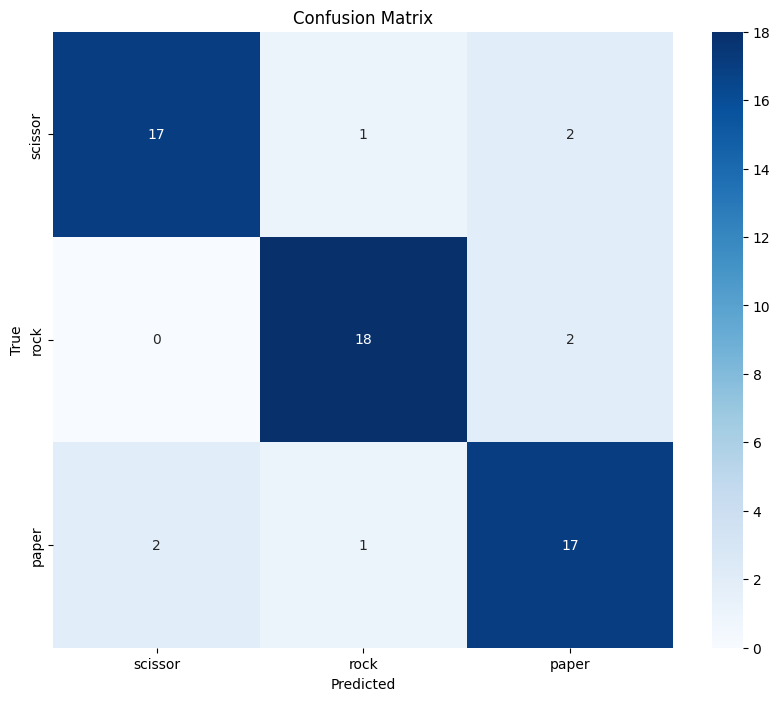

In [31]:
# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**TRUE PREDICTION IMAGES** : Where are the images being clearly matched.

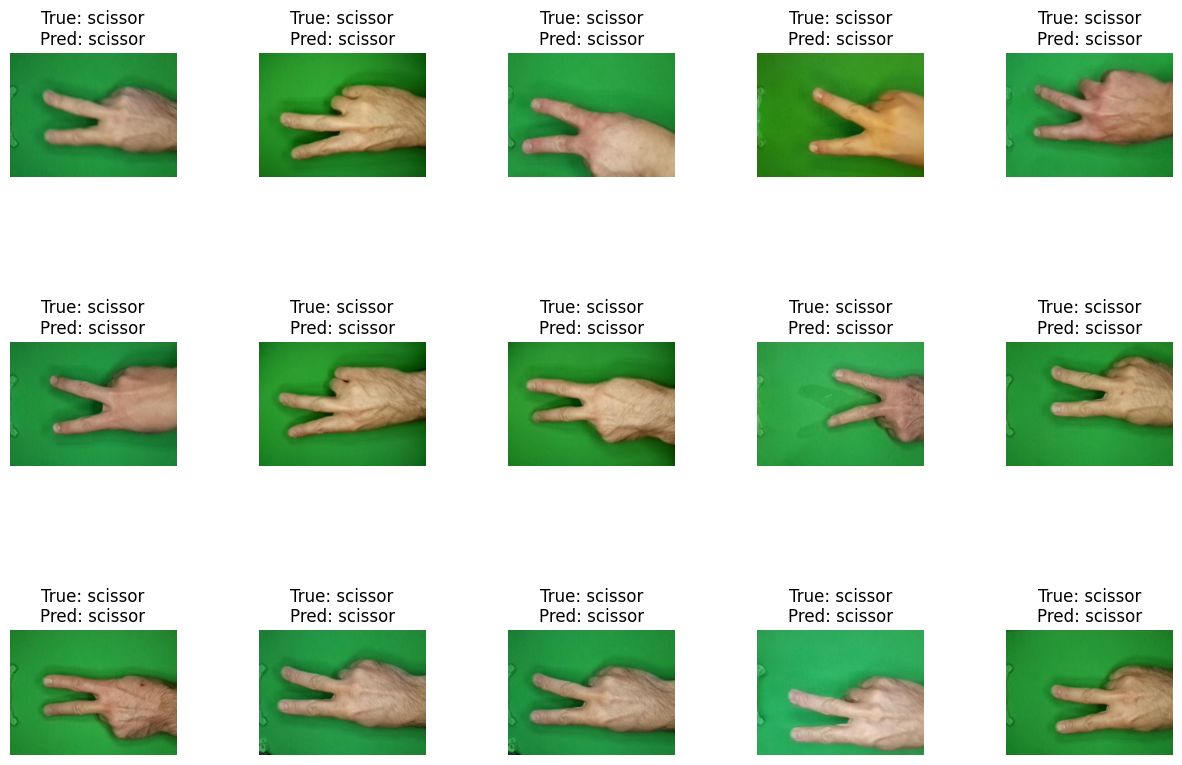

In [32]:
# Visualize true predictions
plt.figure(figsize=(15, 10))
for i, (x, y, p) in enumerate(true_preds[0:15]):
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title(f"True: {class_name[int(y)]}\nPred: {class_name[int(p)]}", fontsize=12)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

**FALSE PREDICTION IMAGES** : Let's see images we can not recognize.  These should probably be replaced.

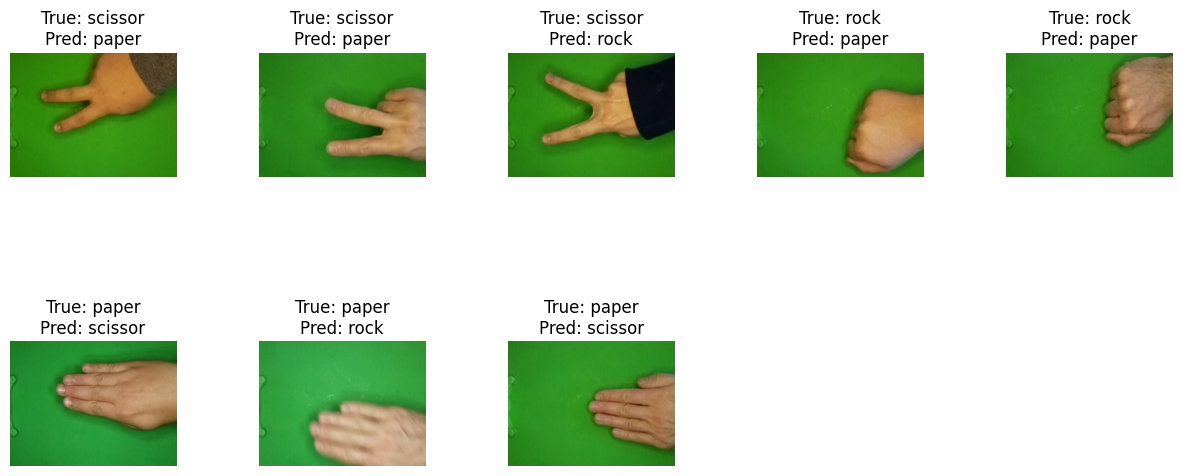

In [33]:
# Visualize false predictions
plt.figure(figsize=(15, 10))
for i, (x, y, p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    plt.title(f"True: {class_name[int(y)]}\nPred: {class_name[int(p)]}", fontsize=12)
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [34]:
from google.colab import drive
drive.flush_and_unmount()